In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
import time
import math
import copy

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = datasets.ImageFolder(root="/kaggle/input/pest-training/Training_Data/Training_Data", transform=transform)
val_dataset = datasets.ImageFolder(root="/kaggle/input/pest-training/Validation_Data/Validation_Data", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10, spline_order=4, 
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0, 
                 enable_standalone_scale_spline=True, grid_eps=0.01, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = nn.SiLU()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) *
                                          self.curve2coeff(self.grid.T[self.spline_order: -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k + 1)]) / (grid[:, k:-1] - grid[:, :-(k + 1)]) * bases[:, :, :-1]) + \
                    ((grid[:, k + 1:] - x) / (grid[:, k + 1:] - grid[:, 1:(-k)]) * bases[:, :, 1:])

        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)  
        B = y.transpose(0, 1)  
        solution = torch.linalg.lstsq(A, B).solution  
        result = solution.permute(2, 0, 1)

        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        x = x.to(self.grid.device)  
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1),
                                 self.scaled_spline_weight.view(self.out_features, -1))
        output = base_output + spline_output
    
        output = output.view(*original_shape[:-1], self.out_features)
        return output

In [4]:
class DensenetKANModel(nn.Module):
    def __init__(self, num_classes=22):
        super(DensenetKANModel, self).__init__()
        self.densenet = models.densenet201(pretrained=True)
        self.kan_layer = KANLinear(in_features=self.densenet.classifier.in_features, 
                                   out_features=num_classes)
        self.densenet.classifier = nn.Identity()  

    def forward(self, x):
        x = self.densenet(x)  
        x = self.kan_layer(x) 
        return x

In [5]:
num_classes = 22
learning_rate = 0.001
num_epochs = 40
patience = 40

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DensenetKANModel(num_classes=22).to(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scaler = torch.cuda.amp.GradScaler()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 61.0MB/s]
/tmp/ipykernel_30/504982819.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.c

In [7]:
best_model = copy.deepcopy(model)
best_acc = 0.0
epochs_no_improve = 0
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    start_time = time.time()

    print(f'Epoch {epoch+1}/{num_epochs}')
    
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with autocast():  
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total
    train_acc_history.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            with autocast():  
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_acc_history.append(val_acc)

    epoch_time = (time.time() - start_time) / 60
    print(f'Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Time: {epoch_time:.2f} min')

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break

torch.save(best_model, 'best_model.pth')



Epoch 1/40


/tmp/ipykernel_30/976573936.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipykernel_30/976573936.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision during validation


Train Accuracy: 0.7881, Val Accuracy: 0.8325, Time: 8.27 min
Epoch 2/40
Train Accuracy: 0.8629, Val Accuracy: 0.8572, Time: 8.20 min
Epoch 3/40
Train Accuracy: 0.8930, Val Accuracy: 0.8836, Time: 8.19 min
Epoch 4/40
Train Accuracy: 0.9159, Val Accuracy: 0.9024, Time: 8.21 min
Epoch 5/40
Train Accuracy: 0.9305, Val Accuracy: 0.8779, Time: 8.20 min
Epoch 6/40
Train Accuracy: 0.9418, Val Accuracy: 0.9139, Time: 8.20 min
Epoch 7/40
Train Accuracy: 0.9490, Val Accuracy: 0.9133, Time: 8.20 min
Epoch 8/40
Train Accuracy: 0.9585, Val Accuracy: 0.9071, Time: 8.20 min
Epoch 9/40
Train Accuracy: 0.9614, Val Accuracy: 0.9158, Time: 8.19 min
Epoch 10/40
Train Accuracy: 0.9650, Val Accuracy: 0.9105, Time: 8.21 min
Epoch 11/40
Train Accuracy: 0.9710, Val Accuracy: 0.9072, Time: 8.19 min
Epoch 12/40
Train Accuracy: 0.9704, Val Accuracy: 0.9200, Time: 8.20 min
Epoch 13/40
Train Accuracy: 0.9714, Val Accuracy: 0.9149, Time: 8.20 min
Epoch 14/40
Train Accuracy: 0.9767, Val Accuracy: 0.9265, Time: 8.20 mi

NameError: name 'plt' is not defined

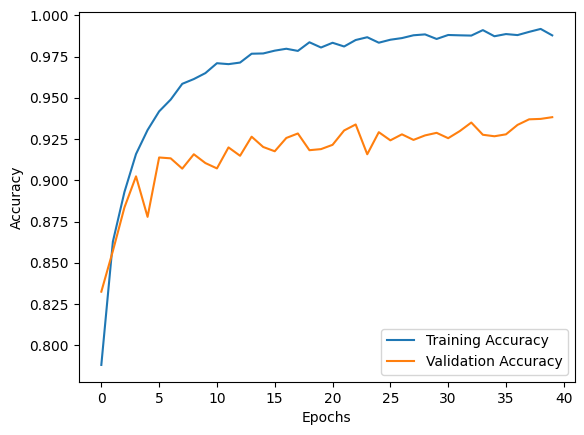

In [8]:
import matplotlib.pyplot as plt
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()